# Data Ingest

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tfhub

import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data'

IMG_SIZE = (224,224)
CLASS_LABELS = ["Coast", "Desert", "Forest", "Glacier", "Mountain"]
TF_RANDOM_SEED = 42

def make_data_gen(dir_location):
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
    return data_gen.flow_from_directory(dir_location,
                                              target_size=IMG_SIZE,
                                              classes=CLASS_LABELS,
                                              class_mode='sparse',
                                              seed=TF_RANDOM_SEED)
train_data = make_data_gen(TRAIN_DIR)

Found 10000 images belonging to 5 classes.


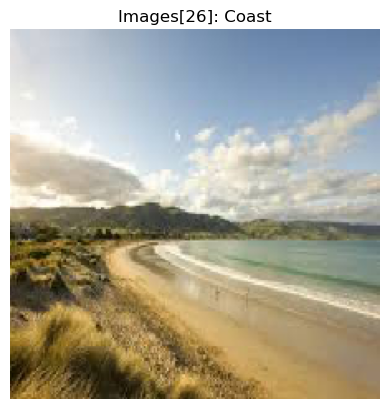

In [3]:
def show_random_image(dir_iter):
    batch_index = 0
    img_index = np.random.randint(32)
    label = CLASS_LABELS[int(dir_iter[batch_index][1][img_index])]

    plt.imshow(dir_iter[batch_index][0][img_index])
    plt.title(f"Images[{img_index}]: {label}")
    plt.axis("off")
    plt.show()

show_random_image(train_data)

Found 1500 images belonging to 5 classes.


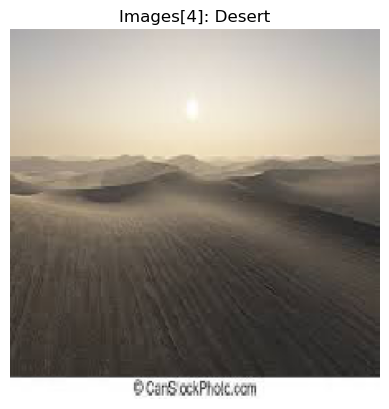

In [4]:
VALID_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Validation Data'

valid_data = make_data_gen(VALID_DIR)
show_random_image(valid_data)

Found 500 images belonging to 5 classes.


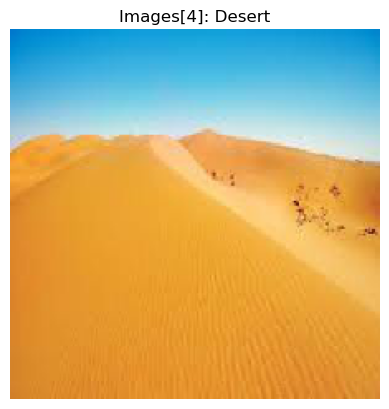

In [5]:
TEST_DIR = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Testing Data'

test_data = make_data_gen(TEST_DIR)
show_random_image(test_data)

# Model 1 - Vanilla Neural Network

In [6]:
tf.random.set_seed(TF_RANDOM_SEED)

dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation="relu",
                          input_shape=IMG_SIZE + (3,)),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")
])

dense_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

dense_history = dense_model.fit(train_data, 
                            epochs=5,
                            steps_per_epoch=len(train_data),
                            validation_data=valid_data,
                            validation_steps=len(valid_data))

Epoch 1/5
313/313 [==============================] - 66s 204ms/step - loss: 1.1488 - accuracy: 0.5981 - val_loss: 1.0587 - val_accuracy: 0.5867
Epoch 2/5
313/313 [==============================] - 48s 153ms/step - loss: 0.8840 - accuracy: 0.6693 - val_loss: 0.9881 - val_accuracy: 0.6307
Epoch 3/5
313/313 [==============================] - 48s 153ms/step - loss: 0.8324 - accuracy: 0.6872 - val_loss: 0.9906 - val_accuracy: 0.6187
Epoch 4/5
313/313 [==============================] - 48s 153ms/step - loss: 0.7933 - accuracy: 0.7056 - val_loss: 0.9915 - val_accuracy: 0.6147
Epoch 5/5
313/313 [==============================] - 48s 152ms/step - loss: 0.7235 - accuracy: 0.7362 - val_loss: 1.0246 - val_accuracy: 0.6220


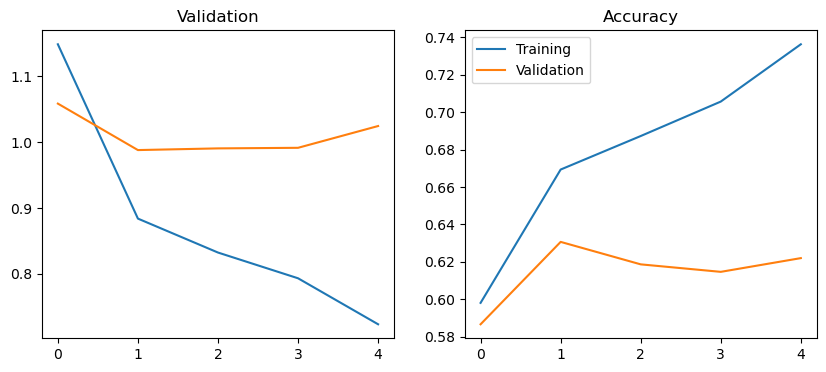

In [7]:
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label="Training")
    plt.plot(history.history['val_loss'], label="Validation")
    plt.title("Validation")
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'], label="Training")
    plt.plot(history.history['val_accuracy'], label="Validation")
    plt.title("Accuracy")
    
    plt.legend()
    plt.show()
    
plot_history(dense_history)

In [8]:
def evaluate_model(model):
    metrics = model.evaluate(test_data)
    print(f"Accuracy: {metrics[1] * 100:.2f}%")

evaluate_model(dense_model)

16/16 [==============================] - 3s 171ms/step - loss: 0.8419 - accuracy: 0.6860
Accuracy: 68.60%


# Model 2 - Convolutional Neural Network

In [9]:
tf.random.set_seed(TF_RANDOM_SEED)

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation="relu",
                          input_shape=IMG_SIZE + (3,)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(CLASS_LABELS), activation="softmax")
])

cnn_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

cnn_history = cnn_model.fit(train_data, 
                            epochs=5,
                            steps_per_epoch=len(train_data),
                            validation_data=valid_data,
                            validation_steps=len(valid_data))

Epoch 1/5
313/313 [==============================] - 38s 106ms/step - loss: 0.9715 - accuracy: 0.6162 - val_loss: 0.9973 - val_accuracy: 0.6313
Epoch 2/5
313/313 [==============================] - 34s 108ms/step - loss: 0.7949 - accuracy: 0.6990 - val_loss: 0.9131 - val_accuracy: 0.6547
Epoch 3/5
313/313 [==============================] - 34s 108ms/step - loss: 0.7093 - accuracy: 0.7356 - val_loss: 0.9319 - val_accuracy: 0.6367
Epoch 4/5
313/313 [==============================] - 34s 109ms/step - loss: 0.5832 - accuracy: 0.7875 - val_loss: 1.0410 - val_accuracy: 0.6593
Epoch 5/5
313/313 [==============================] - 33s 106ms/step - loss: 0.4457 - accuracy: 0.8416 - val_loss: 1.1151 - val_accuracy: 0.6360


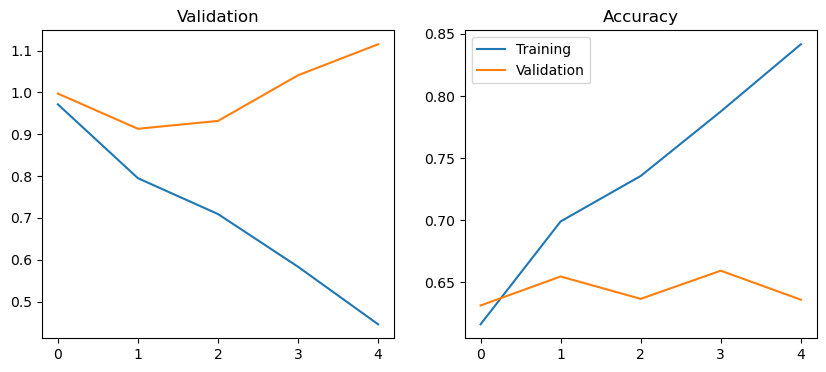

In [10]:
plot_history(cnn_history)

In [11]:
evaluate_model(cnn_model)

16/16 [==============================] - 1s 82ms/step - loss: 0.8278 - accuracy: 0.7380
Accuracy: 73.80%


# Model 2 - EfficientNet

In [12]:
tf.random.set_seed(TF_RANDOM_SEED)

feature_extractor = tfhub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1", 
                                     trainable=False, 
                                     input_shape=IMG_SIZE + (3,))

eff_net_model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(len(CLASS_LABELS), activation='softmax')
])

eff_net_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

eff_net_history = eff_net_model.fit(train_data, 
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data))

Epoch 1/5
313/313 [==============================] - 43s 111ms/step - loss: 0.5367 - accuracy: 0.8274 - val_loss: 0.5084 - val_accuracy: 0.8253
Epoch 2/5
313/313 [==============================] - 33s 105ms/step - loss: 0.3397 - accuracy: 0.8894 - val_loss: 0.4724 - val_accuracy: 0.8333
Epoch 3/5
313/313 [==============================] - 34s 110ms/step - loss: 0.3018 - accuracy: 0.8989 - val_loss: 0.4750 - val_accuracy: 0.8307
Epoch 4/5
313/313 [==============================] - 34s 108ms/step - loss: 0.2784 - accuracy: 0.9090 - val_loss: 0.4870 - val_accuracy: 0.8267
Epoch 5/5
313/313 [==============================] - 34s 109ms/step - loss: 0.2612 - accuracy: 0.9155 - val_loss: 0.4709 - val_accuracy: 0.8353


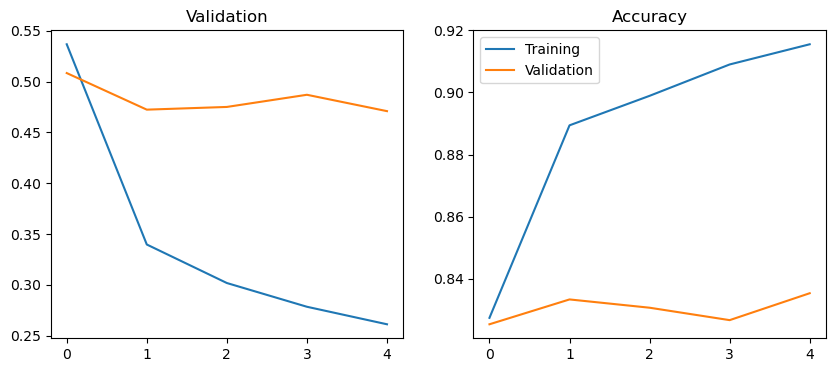

In [13]:
plot_history(eff_net_history)

In [14]:
evaluate_model(eff_net_model)

16/16 [==============================] - 2s 99ms/step - loss: 0.2893 - accuracy: 0.8880
Accuracy: 88.80%


# Model 3 - ResNet

In [15]:
tf.random.set_seed(TF_RANDOM_SEED)

feature_extractor = tfhub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4", 
                                     trainable=False, 
                                     input_shape=IMG_SIZE + (3,))

resnet_model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(len(CLASS_LABELS), activation='softmax')
])

resnet_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

resnet_history = eff_net_model.fit(train_data, 
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data))

Epoch 1/5
313/313 [==============================] - 38s 119ms/step - loss: 0.2484 - accuracy: 0.9174 - val_loss: 0.4734 - val_accuracy: 0.8313
Epoch 2/5
313/313 [==============================] - 33s 107ms/step - loss: 0.2357 - accuracy: 0.9252 - val_loss: 0.4886 - val_accuracy: 0.8300
Epoch 3/5
313/313 [==============================] - 34s 108ms/step - loss: 0.2270 - accuracy: 0.9291 - val_loss: 0.4674 - val_accuracy: 0.8380
Epoch 4/5
313/313 [==============================] - 34s 110ms/step - loss: 0.2177 - accuracy: 0.9314 - val_loss: 0.4563 - val_accuracy: 0.8400
Epoch 5/5
313/313 [==============================] - 34s 107ms/step - loss: 0.2088 - accuracy: 0.9352 - val_loss: 0.4827 - val_accuracy: 0.8300


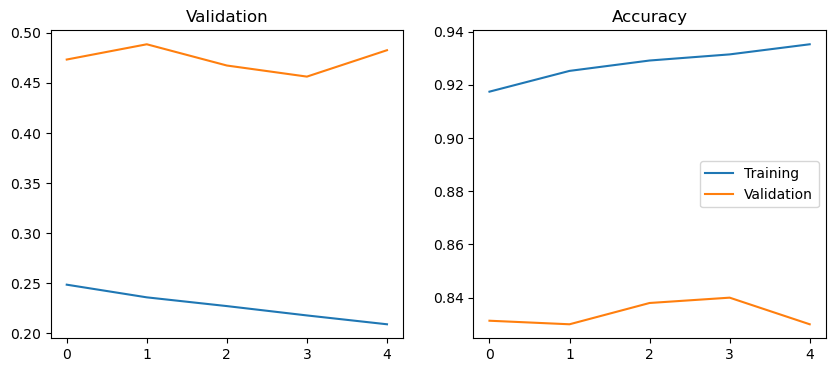

In [16]:
plot_history(resnet_history)

In [17]:
evaluate_model(resnet_model)

16/16 [==============================] - 3s 110ms/step - loss: 1.8645 - accuracy: 0.2420
Accuracy: 24.20%
